# 1. Preliminary Setup


## 1.1 Library

In [ ]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import json

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model, Model

from google.colab import drive

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# print(tf.__version__)

# 2. Setting

## 2.1 Data setting

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define directories
base_dir = '/content/drive/My Drive/AAAI/DR_data_cropped_classes'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

BATCH_SIZE = 32
EPOCHS = 5
IMAGE_SIZE = (150, 150)

tf.random.set_seed(0)

# Mapping class names to numerical labels
CLASSES = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

# Function to shuffle and trim the dataframe to a multiple of BATCH_SIZE
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=42)
    df.reset_index(drop=True, inplace=True)
    df = df[:df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

# Loading and preprocessing training data
filenames = tf.io.gfile.glob(train_dir + '/*/*.jpeg')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)

print("#"*50)
print('Train sample(before separation): ', len(image_path_df_train), dict(image_path_df_train['class'].value_counts()))

# Splitting the training set further into training and validation sets
image_path_df_train, image_path_df_val = train_test_split(image_path_df_train, test_size=0.2, random_state=42, stratify=image_path_df_train['class'])

# Converting the values in 'class' column to string type
image_path_df_train['class'] = image_path_df_train['class'].astype(str)
image_path_df_val['class'] = image_path_df_val['class'].astype(str)

# Loading test data
filenames = tf.io.gfile.glob(test_dir + '/*/*.jpeg')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_test['class'] = image_path_df_test['class'].astype(str)

# image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating generators for training, validation, and test data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=image_path_df_train,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=image_path_df_val,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=image_path_df_test,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print("#"*50)
print('Train sample: ', len(image_path_df_train), dict(image_path_df_train['class'].value_counts()))
print('Val sample: ', len(image_path_df_val), dict(image_path_df_val['class'].value_counts()))
print('Test sample: ', len(image_path_df_test), dict(image_path_df_test['class'].value_counts()))
print("#"*50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
##################################################
Train sample(before separation):  4081 {0: 901, 1: 900, 2: 900, 3: 772, 4: 608}
Found 3264 validated image filenames belonging to 5 classes.
Found 817 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
##################################################
Train sample:  3264 {'0': 721, '1': 720, '2': 720, '3': 617, '4': 486}
Val sample:  817 {'0': 180, '1': 180, '2': 180, '3': 155, '4': 122}
Test sample:  500 {'4': 100, '1': 100, '3': 100, '2': 100, '0': 100}
##################################################


## 2.2. Get images and labels arrays

In [ ]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)

    labels = df.loc[:, 'class']
    return images, labels
train_images, train_labels = get_images_and_labels_arrays(image_path_df_train)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')

val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')

test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')


Shape of train set: (3264, 150, 150, 3)
Shape of train set: (3264,)
Shape of validation set: (817, 150, 150, 3)
Shape of validation set: (817,)
Shape of test set: (500, 150, 150, 3)
Shape of test set: (500,)


## 2.3. Save and Load images and labels set

In [ ]:
# Specify the full file path
save_dir = '/content/drive/My Drive/AAAI'

# Saving the training set
np.save(f'{save_dir}/train_images.npy', train_images)
np.save(f'{save_dir}/train_labels.npy', train_labels)

# Saving the validation set
np.save(f'{save_dir}/val_images.npy', val_images)
np.save(f'{save_dir}/val_labels.npy', val_labels)

# Saving the test set
np.save(f'{save_dir}/test_images.npy', test_images)
np.save(f'{save_dir}/test_labels.npy', test_labels)


In [ ]:
# Specify the full file path
save_dir = '/content/drive/My Drive/AAAI'

# Load the training set
train_images = np.load(f'{save_dir}/train_images.npy')
train_labels = np.load(f'{save_dir}/train_labels.npy', allow_pickle=True)  # Allowing pickle

# Load the validation set
val_images = np.load(f'{save_dir}/val_images.npy')
val_labels = np.load(f'{save_dir}/val_labels.npy', allow_pickle=True)  # Allowing pickle

# Load the test set
test_images = np.load(f'{save_dir}/test_images.npy')
test_labels = np.load(f'{save_dir}/test_labels.npy', allow_pickle=True)  # Allowing pickle

# 3. Model

## 3.1. Create the model

In [ ]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input')

        x = pretrained_model(input_layer)
        x = layers.BatchNormalization()(x)  # move batch normalization before activation function
        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)  # Place batch normalization before each fully connected layer
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)  # Add a dropout layer (here a ratio of 0.3 as an example)

        x = layers.Dense(128)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)

        output = layers.Dense(units=len(CLASSES),
                              activation='softmax',
                              name='output')(x)

        model = Model(input_layer, output)
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model

model = create_model()
model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                              

## 3.2. Train the model

In [ ]:
train_labels = train_labels.astype('float32')
val_labels = val_labels.astype('float32')
test_labels = test_labels.astype('float32')

init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE,
                    epochs=3,
                    callbacks=[learning_rate_reduction, early_stopping],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/3
102/102 [==============================] - 1246s 12s/step - loss: 1.7268 - accuracy: 0.2800 - val_loss: 1.4650 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 2/3
102/102 [==============================] - 1226s 12s/step - loss: 1.4532 - accuracy: 0.3833 - val_loss: 1.4285 - val_accuracy: 0.3794 - lr: 0.0010
Epoch 3/3
102/102 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.4231
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
102/102 [==============================] - 1181s 12s/step - loss: 1.3384 - accuracy: 0.4231 - val_loss: 1.4728 - val_accuracy: 0.3672 - lr: 0.0010

Required time:  1:01:28.423613



## 3.3. Save and Load the model

In [ ]:
# Specify the path to the directory where the model will be saved
save_dir = '/content/drive/My Drive/AAAI'

# Save the model
model.save(f'{save_dir}/test2.keras')

# Save training history in JSON format
history_data = {k: [float(val) for val in v] for k, v in trained.history.items()}
with open(history_path, 'w') as f:
    json.dump(history_data, f)

In [ ]:
# Load the model data
model = load_model(f'{save_dir}/test2.keras')
model.summary()

# Ensure test_images and test_labels are numpy arrays
train_labels = train_labels.astype('float32')
val_labels = val_labels.astype('float32')
test_labels = test_labels.astype('float32')

# Load saved training history
with open(history_path, 'r') as f:
    loaded_history = json.load(f)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024  

# 4. Evaluation

## 4.1. Training and Validation result


The graph if you train the model

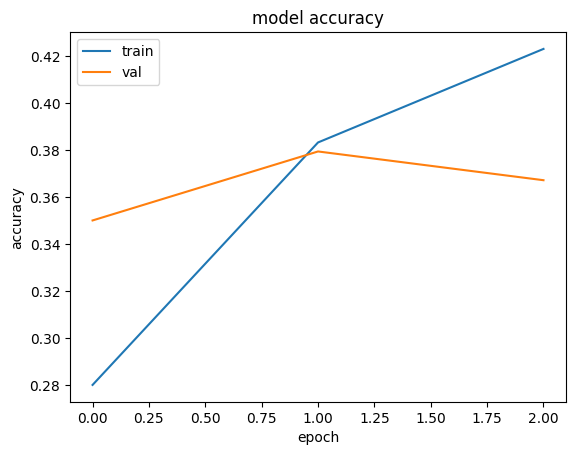

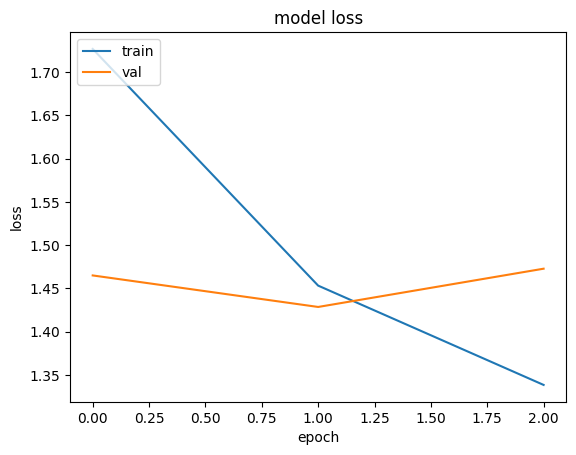

In [ ]:
def plot(wut):
    plt.plot(trained.history[f'{wut}'])
    plt.plot(trained.history[f'val_{wut}'])
    plt.title(f'model {wut}')
    plt.ylabel(f'{wut}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot('accuracy')
plot('loss')

The graph if you load the model

In [ ]:
def plot(wut):
    plt.plot(loaded_history[wut])
    plt.plot(loaded_history[f'val_{wut}'])
    plt.title(f'model {wut}')
    plt.ylabel(wut)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot('accuracy')
plot('loss')

## 4.2. Accuracy and Loss

In [ ]:
# Now try to evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ', test_loss)



accuracy: 0.36800000071525574   loss:  1.523085355758667


## 4.3 Confusion Matrix

16/16 [==============================] - 144s 9s/step
Classification Report


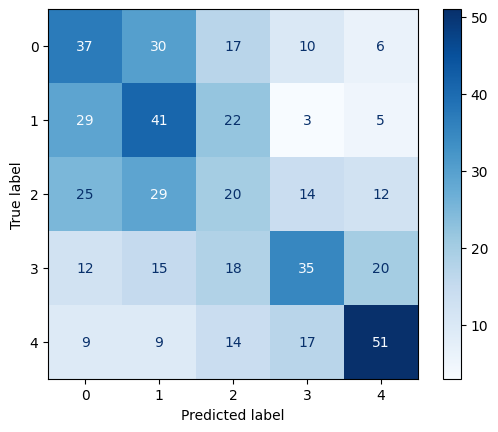

              precision    recall  f1-score   support

           0       0.33      0.37      0.35       100
           1       0.33      0.41      0.37       100
           2       0.22      0.20      0.21       100
           3       0.44      0.35      0.39       100
           4       0.54      0.51      0.53       100

    accuracy                           0.37       500
   macro avg       0.37      0.37      0.37       500
weighted avg       0.37      0.37      0.37       500



In [ ]:
Y_pred = model.predict(test_images)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(test_labels, y_pred, labels=[0,1,2,3,4], target_names=target_names))

## 4.4. Comparison between correct and miscrassified

In [ ]:
classified_examples = {}
for index in range(len(test_labels)):
    actual_label = test_labels[index]
    if actual_label < 5:
        if actual_label not in classified_examples:
            classified_examples[actual_label] = {'correct': None, 'misclassified': None}

        if test_labels[index] == y_pred[index] and classified_examples[actual_label]['correct'] is None:
            classified_examples[actual_label]['correct'] = test_images[index]
        elif test_labels[index] != y_pred[index] and classified_examples[actual_label]['misclassified'] is None:
            classified_examples[actual_label]['misclassified'] = (test_images[index], y_pred[index])

# Get index of correctly classified images
correctly_classified_indices = np.where(test_labels == y_pred)[0]

# Select 3 correctly classified images for each class
correctly_classified_examples = {}
for index in correctly_classified_indices:
    actual_label = test_labels[index]
    if actual_label < 5:
        if actual_label not in correctly_classified_examples:
            correctly_classified_examples[actual_label] = []
        if len(correctly_classified_examples[actual_label]) < 3:
            correctly_classified_examples[actual_label].append(test_images[index])

sorted_classified_examples = dict(sorted(classified_examples.items()))

# Display 3 correctly classified images and 1 misclassified image from each class
fig, axes = plt.subplots(len(sorted_classified_examples), 4, figsize=(10, 10))
for i, (actual_label, correct_images) in enumerate(sorted_classified_examples.items()):
    for j in range(3):
        if j < len(correctly_classified_examples[actual_label]):
            axes[i, j].imshow(correctly_classified_examples[actual_label][j])
            axes[i, j].set_title(f'Correct: {actual_label}')
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

    # Viewing misclassified images
    misclassified_image, predicted_label = classified_examples[actual_label]['misclassified']
    axes[i, 3].imshow(misclassified_image)
    axes[i, 3].set_title(f'Misclassified: {actual_label}, Predicted: {predicted_label}')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


## 4.5. Attention map

In [ ]:
vgg19_layer = model.get_layer('vgg19')
vgg19_layer.summary()
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
tf.get_logger().setLevel('ERROR')

# Function to generate a Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Retrieve the last convolutional layer from within the VGG19 model
    vgg19 = model.get_layer('vgg19')
    last_conv_layer = vgg19.get_layer(last_conv_layer_name)

    # Get the output up to the last convolutional layer through the VGG19 model
    vgg19_output = last_conv_layer.output

    # Apply classification layers
    x = vgg19_output
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)

    # Create the Grad-CAM model
    grad_model = Model(inputs=vgg19.input, outputs=[vgg19_output, x])

    # Grad-CAM algorithm
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_id = tf.argmax(predictions[0])
        loss = predictions[:, class_id]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap[0]

# Grad-CAM and a function to display the original image
def display_gradcam_and_original(img_path, heatmap, cls, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.resize(jet, (img_width, img_height))
    superimposed_img = jet * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image #" + cls)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Setting parameters
test_dir = '/content/drive/My Drive/AAAI/DR_data_cropped_classes/test'
img_width, img_height = 150, 150
classes = ['0', '1', '2', '3', '4']
last_conv_layer_name = 'block5_conv4'

# depends on the model layers
# classifier_layer_names = ['global_average_pooling2d', 'batch_normalization', 'dense', 'batch_normalization_1', 'dense_1', 'output']
classifier_layer_names = [
    'batch_normalization',
    'global_average_pooling2d',
    'dense',
    'batch_normalization_1',
    'activation',
    'dropout',
    'dense_1',
    'batch_normalization_2',
    'activation_1',
    'dropout_1',
    'output'
]

# Generate and display a heatmap for the first image of each class
for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)
    display_gradcam_and_original(img_path, heatmap, cls)


# 5. Reference
https://github.com/P-stha12/a-eye.ai/blob/main/ML/final.ipynb